In [ ]:
from google.colab import drive
import os

# Mount Google Drive to /content/drive
drive.mount('/content/drive')

# Create a folder for your models if it doesn't exist
save_dir = '/content/drive/My Drive/Maintenance_RL_Models'
os.makedirs(save_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
from collections import deque

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import datetime

In [ ]:
class FlowLineEnvironment:
    """
    Flow-line manufacturing system with maintenance decisions
    """
    def __init__(self,
                 machines_per_stage=[2, 2],
                 production_per_stage=100,  # WIPs per machine per timestep per stage
                 buffer_capacity=1_400,
                 buffer_cycle=7,
                 arrival_lambda=1_200,
                 max_machine_age=None,
                 episode_length=1_000,
                 failure_distribution='weibull',
                 weibull_k=2,
                 weibull_lambda=30,
                 linear_failure_rate=0.01,
                 pm_age_reduction=14,
                 pm_duration=2,
                 cm_duration=5,
                 pm_cost=6_000,
                 cm_cost=8_000,
                 blockage_cost=10,
                 starvation_cost=5):
        """
        Args:
            machines_per_stage: List of number of machines per stage [m_1, m_2, ...]
            production_per_stage: List of production capacity per stage
            buffer_capacity: Maximum capacity of each buffer
            buffer_cycle: Poisson arrival parameter (lambda = 1/buffer_cycle * 1200)
            max_machine_age: Maximum age for state representation
            episode_length: Number of timesteps per episode
            failure_distribution: 'weibull' or 'linear'
            weibull_k: Weibull shape parameter
            weibull_lambda: Weibull scale parameter
            linear_failure_rate: Failure rate per timestep for linear distribution
            pm_age_reduction: How much PM reduces machine age
            pm_duration: Timesteps required for PM
            cm_duration: Timesteps required for CM
            pm_cost: Cost of performing PM
            cm_cost: Cost of performing CM (automatic on failure)
            blockage_cost: Cost per WIP per timestep when blocked
            starvation_cost: Cost per machine per timestep when starved
        """
        self.machines_per_stage = machines_per_stage
        self.num_stages = len(machines_per_stage)
        self.total_machines = sum(machines_per_stage)

        # Production capacity per stage (default 100 for all stages)
        if type(production_per_stage) == int:
            self.production_per_stage = [production_per_stage] * self.num_stages
        else:
            assert type(production_per_stage) == list, \
                "production_per_stage must be an integer or a list type"
            self.production_per_stage = production_per_stage
            assert len(production_per_stage) == self.num_stages, \
                "production_per_stage must have same length as machines_per_stage"

        self.buffer_capacity = buffer_capacity
        self.buffer_cycle = buffer_cycle
        self.arrival_lambda = arrival_lambda # Poisson lambda
        self.max_machine_age = max_machine_age
        self.episode_length = episode_length

        # Failure parameters
        self.failure_distribution = failure_distribution
        self.weibull_k = weibull_k
        self.weibull_lambda = weibull_lambda
        self.linear_failure_rate = linear_failure_rate

        if max_machine_age is None:
            self.max_machine_age = self._calculate_max_machine_age()
            print(f"Auto-calculated max_machine_age: {self.max_machine_age}")
        else:
            self.max_machine_age = max_machine_age

        # Maintenance parameters
        self.pm_age_reduction = pm_age_reduction
        self.pm_duration = pm_duration
        self.cm_duration = cm_duration
        self.pm_cost = pm_cost
        self.cm_cost = cm_cost

        # Cost parameters
        self.blockage_cost = blockage_cost
        self.starvation_cost = starvation_cost

        # State size calculation
        # State = [machine_ages, buffer_levels, maintenance_timers, wips_in_machine, wips_held]
        self.state_size = (self.total_machines +  # machine ages
                          self.num_stages +       # buffer levels
                          self.total_machines)    # maintenance timers

        self.action_size = 2  # 0: do nothing, 1: perform PM

        self.reset()

    def _calculate_max_machine_age(self):
        """
        Automatically calculate appropriate max_machine_age based on failure distribution

        Returns a value where machines are very likely to have failed by that age,
        providing good coverage for state normalization.

        For Weibull: Use age where cumulative failure probability ≈ 0.99
        For Linear: Use age where failure probability ≈ 0.99
        """
        if self.failure_distribution == 'weibull':
            # Weibull CDF: F(t) = 1 - exp(-(t/lambda)^k)
            # Solve for t when F(t) = 0.99:
            # 0.99 = 1 - exp(-(t/lambda)^k)
            # exp(-(t/lambda)^k) = 0.01
            # -(t/lambda)^k = ln(0.01)
            # (t/lambda)^k = -ln(0.01) = ln(100)
            # t = lambda * (ln(100))^(1/k)

            target_failure_prob = 0.99
            max_age = self.weibull_lambda * (np.log(1 / (1 - target_failure_prob))) ** (1 / self.weibull_k)

            # Add 20% buffer for safety
            max_age = int(max_age * 1.2)

            # Ensure minimum value
            # max_age = max(max_age, 50)

            return max_age

        elif self.failure_distribution == 'linear':
            # For linear: prob = age * failure_rate
            # Solve for age when prob ≈ 0.99
            # 0.99 = age * failure_rate
            # age = 0.99 / failure_rate

            target_failure_prob = 0.99
            max_age = int(target_failure_prob / self.linear_failure_rate)

            # Add 20% buffer for safety
            max_age = int(max_age * 1.2)

            # Ensure minimum value
            # max_age = max(max_age, 50)

            return max_age

        assert False, "The failure distribution should be 'weibull' or 'linear'"


    def reset(self):
        """Reset environment to initial state"""
        # Machine ages (start at 0)
        self.machine_ages = [0.0] * self.total_machines

        # Buffer levels (start empty except first buffer)
        self.buffer_levels = [0] * self.num_stages
        initial_wips = np.random.poisson(self.arrival_lambda)
        self.buffer_levels[0] = min(initial_wips, self.buffer_capacity)

        # Maintenance timers (0 = not in maintenance)
        self.maintenance_timers = [0] * self.total_machines

        # Machine failed status
        self.machine_failed = [False] * self.total_machines

        # WIPs currently being processed by each machine
        self.wips_in_machine = [0] * self.total_machines

        # WIPs held by machine (blocked, waiting for downstream space)
        self.wips_held = [0] * self.total_machines

        # steps between each arrival of new WIPs at first buffer
        self.wips_arrival_tracker = 0

        self.current_step = 0

        return self._get_state()

    def _get_state(self):
        """
        Construct state vector with normalization

        State variables (all normalized to 0-1):
        1. Machine ages: normalized by max_machine_age
        2. Buffer levels: normalized by buffer_capacity
        3. Maintenance timers: normalized by max(pm_duration, cm_duration)
        4. WIPs in machine: normalized by max production capacity
        5. WIPs held: normalized by max production capacity
        """
        max_maintenance = max(self.pm_duration, self.cm_duration)
        max_production = max(self.production_per_stage)

        # Normalize machine ages (0 to 1)
        normalized_ages = [age / self.max_machine_age for age in self.machine_ages]

        # Normalize buffer levels (0 to 1)
        normalized_buffers = [level / self.buffer_capacity for level in self.buffer_levels]

        # Normalize maintenance timers (0 to 1)
        normalized_timers = [timer / max_maintenance for timer in self.maintenance_timers]

        # Normalize WIPs in machine (0 to 1)
        normalized_wips_in = [wips / max_production for wips in self.wips_in_machine]

        # Normalize WIPs held (0 to 1)
        normalized_wips_held = [wips / max_production for wips in self.wips_held]

        state = np.array(
            normalized_ages + normalized_buffers + normalized_timers,
            dtype=np.float32
        )
        return state

    def _calculate_failure_probability(self, age):
        """Calculate failure probability based on machine age"""
        if self.failure_distribution == 'weibull':
            if age <= 0:
                return 0.0
            hazard = (self.weibull_k / self.weibull_lambda) * \
                    (age / self.weibull_lambda) ** (self.weibull_k - 1)
            prob = 1 - np.exp(-hazard)
            return min(prob, 1.0)

        elif self.failure_distribution == 'linear':
            prob = age * self.linear_failure_rate
            return min(prob, 1.0)

        else:
            raise ValueError(f"Unknown failure distribution: {self.failure_distribution}")

    def _get_machine_stage(self, machine_idx):
        """Get which stage a machine belongs to"""
        cumulative = 0
        for stage_idx, num_machines in enumerate(self.machines_per_stage):
            if machine_idx < cumulative + num_machines:
                return stage_idx
            cumulative += num_machines
        return -1

    def _get_stage_machines(self, stage_idx):
        """Get indices of machines in a given stage"""
        start_idx = sum(self.machines_per_stage[:stage_idx])
        end_idx = start_idx + self.machines_per_stage[stage_idx]
        return list(range(start_idx, end_idx))

    def step(self, actions):
        """
        Execute one timestep with your specified flow logic

        Flow order:
        Phase 1 (Downstream to Upstream):
          - For each stage from last to first:
            1. Deliver completed WIPs
            2. Check for failures
            3. Pick up new WIPs if possible

        Phase 2 (Upstream to Downstream - Backfill):
          - For each stage from first to last:
            1. Machines that didn't reach capacity try to pick up more

        Args:
            actions: List of actions (0 or 1) for each machine

        Returns:
            next_state, reward
        """
        total_cost = 0.0

        # ==================== MAINTENANCE PROCESSING ====================
        # 1. Process maintenance actions and update maintenance timers
        for machine_idx, action in enumerate(actions):
            # If machine is currently in maintenance, decrement timer
            if self.maintenance_timers[machine_idx] > 0:
                self.maintenance_timers[machine_idx] -= 1
                # When maintenance completes
                if self.maintenance_timers[machine_idx] == 0:
                    self.machine_failed[machine_idx] = False

            # If not in maintenance and action is PM (and machine not failed)
            elif action == 1 and not self.machine_failed[machine_idx]:
                # Perform PM
                self.machine_ages[machine_idx] = max(0, self.machine_ages[machine_idx] - self.pm_age_reduction)
                self.maintenance_timers[machine_idx] = self.pm_duration
                total_cost += self.pm_cost

        # ==================== PHASE 1: DOWNSTREAM TO UPSTREAM ====================
        # Process stages from last to first
        for stage_idx in range(self.num_stages - 1, -1, -1):
            stage_machines = self._get_stage_machines(stage_idx)
            stage_production_capacity = self.production_per_stage[stage_idx]

            for machine_idx in stage_machines:
                # Skip if in maintenance
                if self.maintenance_timers[machine_idx] > 0:
                    # Add the production cost to the loss
                    total_cost += stage_production_capacity
                    continue

                # ===== STEP 1: DELIVER COMPLETED WIPs =====
                wips_to_deliver = self.wips_in_machine[machine_idx] + self.wips_held[machine_idx]

                if wips_to_deliver > 0:
                    if stage_idx == self.num_stages - 1:
                        # Last stage: WIPs leave system (completed)
                        self.wips_in_machine[machine_idx] = 0
                        self.wips_held[machine_idx] = 0
                    else:
                        # Not last stage: try to deliver to next buffer
                        next_buffer_idx = stage_idx + 1
                        space_available = self.buffer_capacity - self.buffer_levels[next_buffer_idx]

                        if space_available >= wips_to_deliver:
                            # Can deliver all
                            self.buffer_levels[next_buffer_idx] += wips_to_deliver
                            self.wips_in_machine[machine_idx] = 0
                            self.wips_held[machine_idx] = 0
                        else:
                            # Partial delivery or still blocked
                            self.buffer_levels[next_buffer_idx] += space_available
                            wips_remaining = wips_to_deliver - space_available
                            self.wips_in_machine[machine_idx] = 0
                            self.wips_held[machine_idx] = wips_remaining
                            # Blockage cost for held WIPs
                            total_cost += wips_remaining * self.blockage_cost

                # ===== STEP 2: CHECK FOR FAILURE =====
                if not self.machine_failed[machine_idx]:
                    failure_prob = self._calculate_failure_probability(self.machine_ages[machine_idx])
                    if np.random.random() < failure_prob:
                        # Machine fails - start CM
                        self.machine_failed[machine_idx] = True
                        self.maintenance_timers[machine_idx] = self.cm_duration
                        self.machine_ages[machine_idx] = 0.0
                        total_cost += self.cm_cost
                        continue  # Don't pick up WIPs if just failed

                # ===== STEP 3: PICK UP NEW WIPs =====
                # Only if not failed, not in maintenance, and not holding WIPs
                if (not self.machine_failed[machine_idx] and
                    self.maintenance_timers[machine_idx] == 0 and
                    self.wips_held[machine_idx] == 0):

                    # Current buffer (upstream buffer for this stage)
                    current_buffer_idx = stage_idx
                    wips_available = self.buffer_levels[current_buffer_idx]
                    capacity = stage_production_capacity

                    wips_to_pickup = min(wips_available, capacity)

                    if wips_to_pickup > 0:
                        self.buffer_levels[current_buffer_idx] -= wips_to_pickup
                        self.wips_in_machine[machine_idx] = wips_to_pickup
                    # Starvation: additional cost for any WIPs that could've been processed but weren't
                    total_cost += (capacity - wips_to_pickup) * self.starvation_cost
                else:
                    # if failed and cannot process WIPs, production loss
                    total_cost += stage_production_capacity

        # ==================== PHASE 2: UPSTREAM TO DOWNSTREAM (BACKFILL) ====================
        # Process stages from first to last
        for stage_idx in range(self.num_stages):
            stage_machines = self._get_stage_machines(stage_idx)
            stage_production_capacity = self.production_per_stage[stage_idx]

            for machine_idx in stage_machines:
                # Skip if in maintenance, failed, or holding WIPs
                if (self.maintenance_timers[machine_idx] > 0 or
                    self.machine_failed[machine_idx] or
                    self.wips_held[machine_idx] > 0):
                    continue

                # Check if machine didn't reach full capacity
                current_wips = self.wips_in_machine[machine_idx]
                if current_wips < stage_production_capacity:
                    # Try to pick up more WIPs
                    current_buffer_idx = stage_idx
                    wips_available = self.buffer_levels[current_buffer_idx]
                    capacity_remaining = stage_production_capacity - current_wips

                    additional_wips = min(wips_available, capacity_remaining)

                    if additional_wips > 0:
                        self.buffer_levels[current_buffer_idx] -= additional_wips
                        self.wips_in_machine[machine_idx] += additional_wips

        # ==================== NEW WIP ARRIVALS ====================
        # Add new WIPs to first buffer (Poisson arrivals) every start of cycle
        new_arrivals = 0
        # Add before checking because initial WIP arrival is handled by the reset method
        self.wips_arrival_tracker += 1
        if self.wips_arrival_tracker % self.buffer_cycle == 0:

            # reset tracker, but it would be fine if we didn't
            self.wips_arrival_tracker = 0

            new_arrivals = np.random.poisson(self.arrival_lambda)
            space_available = self.buffer_capacity - self.buffer_levels[0]
            added_wips = min(new_arrivals, space_available)
            self.buffer_levels[0] += added_wips

            # If arrivals exceed capacity, they are lost
            if new_arrivals > space_available:
                total_cost += (new_arrivals - space_available) * self.blockage_cost

        # ==================== MACHINE AGING ====================
        # Age machines that are working (not in maintenance and not idle i.e. are processing WIPs)
        for machine_idx in range(self.total_machines):
            if self.maintenance_timers[machine_idx] == 0 and not self.machine_failed[machine_idx] and self.wips_in_machine[machine_idx] > 0:
                self.machine_ages[machine_idx] += 1
                self.machine_ages[machine_idx] = min(self.machine_ages[machine_idx], self.max_machine_age)

        self.current_step += 1

        # Reward is negative cost
        reward = -total_cost

        return self._get_state(), reward

    def is_episode_done(self):
        """Check if episode has reached the end"""
        return self.current_step >= self.episode_length

In [ ]:
# Neural network architecture
class MultiHeadQNetwork(nn.Module):
    """Q-Network with separate heads for each agent (machine)"""
    def __init__(self, state_size, action_size, num_agents, hidden_sizes=[128, 128]):
        super(MultiHeadQNetwork, self).__init__()

        self.num_agents = num_agents
        self.action_size = action_size

        # Shared feature extraction layers
        layers = []
        input_size = state_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        self.shared_layers = nn.Sequential(*layers)

        # Separate output head for each machine
        self.agent_heads = nn.ModuleList([
            nn.Linear(hidden_sizes[-1], action_size) for _ in range(num_agents)
        ])

    def forward(self, state):
        """Returns Q-values for each machine (batch, num_machines, actions)"""
        features = self.shared_layers(state)
        q_values = []
        for head in self.agent_heads:
            q_values.append(head(features))
        return torch.stack(q_values, dim=1)

In [ ]:
class ReplayBuffer:
    """Experience replay buffer"""
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, actions, reward, next_state):
        self.buffer.append((state, actions, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states))

    def __len__(self):
        return len(self.buffer)

    def is_ready(self, batch_size):
        return len(self.buffer) >= batch_size

In [ ]:
class DoubleDQNAgent:
    """Double DQN Agent for maintenance scheduling"""
    def __init__(self, state_size, action_size, num_agents,
                 learning_rate=0.0004, discount_factor=0.95,
                 epsilon_max=1.0, epsilon_min=0.01, epsilon_decay_divisor=3,
                 buffer_capacity=5000, batch_size=128,
                 target_update_frequency=10, train_frequency=5000,
                 lr_decay_factor=0.5, lr_decay_frequency=200):

        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.gamma = discount_factor
        self.epsilon_max = epsilon_max
        self.epsilon = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay_divisor = epsilon_decay_divisor
        self.batch_size = batch_size
        self.target_update_frequency = target_update_frequency
        self.train_frequency = train_frequency
        self.update_counter = 0
        self.episode_count = 0
        self.step_counter = 0

        self.initial_lr = learning_rate
        self.current_lr = learning_rate
        self.lr_decay_factor = lr_decay_factor
        self.lr_decay_frequency = lr_decay_frequency

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = MultiHeadQNetwork(state_size, action_size, num_agents).to(self.device)
        self.target_network = MultiHeadQNetwork(state_size, action_size, num_agents).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_capacity)

    def choose_actions(self, state):
        """Epsilon-greedy action selection for all machines"""
        actions = []

        if np.random.random() < self.epsilon:
            # Explore
            for _ in range(self.num_agents):
                actions.append(np.random.randint(0, self.action_size))
        else:
            # Exploit
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)

            for agent_idx in range(self.num_agents):
                action = q_values[0, agent_idx].argmax().item()
                actions.append(action)

        return actions

    def store_transition(self, state, actions, reward, next_state):
        self.replay_buffer.push(state, actions, reward, next_state)
        self.step_counter += 1

    def save_checkpoint(self, filepath, env_config_dict, last_transitions=None):
        """
        Saves model, training state, and a readable sample for the professor.
        """
        checkpoint = {
            # 1. Models
            'q_network_state': self.q_network.state_dict(),
            'target_network_state': self.target_network.state_dict(),

            # 2. Optimizer & Training State
            'optimizer_state': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'episode_count': self.episode_count,
            'step_counter': self.step_counter,
            'current_lr': self.current_lr,

            # 3. Environment Configuration (Crucial for reloading)
            'env_config': env_config_dict
        }

        torch.save(checkpoint, filepath)
        print(f"Checkpoint saved to {filepath}")

        # 4. Save readable sample
        if last_transitions:
            txt_path = filepath.replace('.pth', '_sample.txt')
            with open(txt_path, 'w') as f:
                f.write("=== SAMPLE STATE TRANSITIONS ===\n\n")
                for i, (s, a, r, ns) in enumerate(last_transitions):
                    f.write(f"--- Transition {i+1} ---\n")
                    f.write(f"State (abbreviated): {np.round(s[:10], 2)}...\n")
                    f.write(f"Action Taken: {a}\n")
                    f.write(f"Reward: {r:.4f}\n")
                    f.write(f"Next State (abbreviated): {np.round(ns[:10], 2)}...\n\n")
            print(f"Sample transitions saved to {txt_path}")

    def load_checkpoint(self, filepath):
        """
        Loads the model and restores training state.
        """
        if not os.path.exists(filepath):
            print("No checkpoint found.")
            return None

        checkpoint = torch.load(filepath, map_location=self.device, weights_only=False)

        # 1. Restore Models
        self.q_network.load_state_dict(checkpoint['q_network_state'])
        self.target_network.load_state_dict(checkpoint['target_network_state'])

        # 2. Restore Optimizer
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])

        # 3. Restore Scalars
        self.epsilon = checkpoint['epsilon']
        self.episode_count = checkpoint['episode_count']
        self.step_counter = checkpoint['step_counter']
        self.current_lr = checkpoint.get('current_lr', self.initial_lr) # Handle backward compatibility

        # Update the optimizer's internal LR to match loaded value
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_lr

        print(f"Successfully loaded model.")
        return checkpoint['env_config']

    def should_train(self):
        return (self.step_counter % self.train_frequency == 0 and
                self.replay_buffer.is_ready(self.batch_size))

    def train(self):
        """Train using Double DQN"""
        if not self.replay_buffer.is_ready(self.batch_size):
            return None

        states, actions, rewards, next_states = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)

        # Current Q-values
        current_q = self.q_network(states)
        current_q_values = []
        for agent_idx in range(self.num_agents):
            agent_actions = actions[:, agent_idx].unsqueeze(1)
            agent_q = current_q[:, agent_idx, :].gather(1, agent_actions).squeeze(1)
            current_q_values.append(agent_q)
        current_q_values = torch.stack(current_q_values, dim=1)

        # Double DQN: select with online, evaluate with target
        with torch.no_grad():
            next_q_online = self.q_network(next_states)
            best_actions = next_q_online.argmax(dim=2)

            next_q_target = self.target_network(next_states)
            next_q_values = []
            for agent_idx in range(self.num_agents):
                agent_best_actions = best_actions[:, agent_idx].unsqueeze(1)
                agent_next_q = next_q_target[:, agent_idx, :].gather(1, agent_best_actions).squeeze(1)
                next_q_values.append(agent_next_q)
            next_q_values = torch.stack(next_q_values, dim=1)

            target_q = rewards.unsqueeze(1) + self.gamma * next_q_values

        loss = F.mse_loss(current_q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter % self.target_update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        return loss.item()

    def decay_epsilon_log10(self):
        if self.epsilon == 0:   # in evaluation mode
            return
        self.episode_count += 1
        decay_term = np.log10(self.episode_count + 1) / self.epsilon_decay_divisor
        self.epsilon = max(self.epsilon_min, min(self.epsilon_max, self.epsilon_max - decay_term))

        if self.lr_decay_frequency > 0 and self.episode_count % self.lr_decay_frequency == 0:
            self.decay_learning_rate()

    def decay_learning_rate(self):
        self.current_lr *= self.lr_decay_factor
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_lr
        print(f"  → Learning rate decayed to: {self.current_lr:.6f}")

    def get_learning_rate(self):
        return self.optimizer.param_groups[0]['lr']

In [ ]:
def train_maintenance_system(env, config, checkpoint_path):
    """
    Train the maintenance scheduling agent with Checkpointing and Resume capability.
    """
    # Initialize Agent using Config
    agent = DoubleDQNAgent(
        state_size=env.state_size,
        action_size=env.action_size,
        num_agents=env.total_machines,
        learning_rate=config['learning_rate'],
        discount_factor=0.95,
        epsilon_max=1.0,
        epsilon_min=0.01,
        epsilon_decay_divisor=config['epsilon_decay_divisor'],
        buffer_capacity=config['buffer_capacity'],
        batch_size=config['batch_size'],
        target_update_frequency=10,
        train_frequency=config['train_frequency'],
        lr_decay_factor=config['lr_decay_factor'],
        lr_decay_frequency=config['lr_decay_frequency']
    )

    rewards_per_episode = []
    losses = []
    epsilon_history = []
    lr_history = []

    # === NEW: RESUME LOGIC ===
    start_episode = 0

    # Try to load previous progress
    loaded_env_config = agent.load_checkpoint(checkpoint_path)

    if loaded_env_config:
        # If load successful, update starting point
        start_episode = agent.episode_count
        print(f"Resuming training from episode {start_episode}...")

        # Optional: Verify environment config matches
        # (This prevents you from loading a model trained on a different environment)
        # if loaded_env_config != config['env_params']:
        #     print("WARNING: Loaded model environment parameters do not match current config!")

    # Buffer for "Professor Sample" (Last 10 transitions)
    recent_transitions = deque(maxlen=10)

    # === TRAINING LOOP ===
    # Notice we start from 'start_episode' instead of 0
    for episode in range(start_episode, config['episodes']):
        state = env.reset()
        total_reward = 0
        episode_losses = []

        while not env.is_episode_done():
            actions = agent.choose_actions(state)
            next_state, reward = env.step(actions)

            agent.store_transition(state, actions, reward, next_state)

            # Store for visualization/debug sample
            recent_transitions.append((state, actions, reward, next_state))

            if agent.should_train():
                loss = agent.train()
                if loss is not None:
                    episode_losses.append(loss)

            total_reward += reward
            state = next_state

        # End of Episode Updates
        agent.decay_epsilon_log10()

        rewards_per_episode.append(total_reward)
        epsilon_history.append(agent.epsilon)
        lr_history.append(agent.get_learning_rate())

        if episode_losses:
            losses.append(np.mean(episode_losses))
        elif losses: # Carry forward previous loss if no training happened this episode
            losses.append(losses[-1])

        # === LOGGING & SAVING ===
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(rewards_per_episode[-50:])
            avg_loss = np.mean(losses[-50:]) if losses else 0

            print(f"Episode {episode + 1}/{config['episodes']} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Loss: {avg_loss:.4f} | "
                  f"ε: {agent.epsilon:.3f} | "
                  f"LR: {agent.get_learning_rate():.6f}")
            print()

            # Save Checkpoint
            # We pass the env_params so we know what settings created this model
            agent.save_checkpoint(
                checkpoint_path,
                env_config_dict=config['env_params'],
                last_transitions=list(recent_transitions)
            )
            print("-" * 70)

    return agent, rewards_per_episode, losses, epsilon_history, lr_history

In [ ]:
def visualize_training(rewards, losses, epsilon, lr):
    """Visualize training results"""
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    window = 50

    # Rewards
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(rewards, alpha=0.3, label='Episode Reward')
    if len(rewards) > window:
        rewards_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(rewards)), rewards_avg, linewidth=2, label='Moving Avg')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Rewards per Episode')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2 = fig.add_subplot(gs[0, 1])
    if losses:
        ax2.plot(losses, alpha=0.5, label='Training Loss')
        if len(losses) > window:
            loss_avg = np.convolve(losses, np.ones(window)/window, mode='valid')
            ax2.plot(range(window-1, len(losses)), loss_avg, linewidth=2, label='Moving Avg')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Loss')
        ax2.set_title('Training Loss')
        ax2.legend()
        ax2.grid(True)

    # Epsilon
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(epsilon, linewidth=2, color='green')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Epsilon')
    ax3.set_title('Exploration Rate')
    ax3.grid(True)

    # Learning rate
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(lr, linewidth=2, color='red')
    ax4.set_xbound(lower=-50, upper=850)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Learning Rate')
    ax4.set_title('Learning Rate Schedule')
    ax4.grid(True)

    # Reward distribution
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
    ax5.axvline(np.mean(rewards), color='r', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(rewards):.2f}')
    ax5.set_xlabel('Total Reward')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Reward Distribution')
    ax5.legend()
    ax5.grid(True)

    # Learning curve with LR decay markers
    ax6 = fig.add_subplot(gs[2, 1])
    if len(rewards) > window:
        rewards_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        decay_points = [i for i in range(0, len(rewards), 200) if i > 0]
        for dp in decay_points:
            ax6.axvline(dp, color='red', linestyle='--', alpha=0.3)
        ax6.plot(range(window-1, len(rewards)), rewards_avg, linewidth=2)
        ax6.set_xlabel('Episode')
        ax6.set_ylabel('Avg Reward')
        ax6.set_title('Learning Curve (LR decay at red lines)')
        ax6.grid(True)
    ax6.set_xbound(lower=-50, upper=850)

    plt.show()

In [ ]:
print("=" * 70)
print("Flow-Line Maintenance Scheduling with Double DQN")
print("=" * 70)

# === CONFIGURATION FOR SIMPLE RUN ===
# Change 'ID' to train a separate model (e.g., "Experiment_A", "Experiment_B")
simple_run_config = {
    "ID": "Experiment_Simple_1_Machine",

    # Training Hyperparameters
    "episodes": 800,
    "episode_length": 1_000,
    "learning_rate": 0.0004,
    "lr_decay_factor": 0.5,
    "lr_decay_frequency": 200,
    "epsilon_decay_divisor": 3,
    "buffer_capacity": 5000,
    "batch_size": 128,
    "train_frequency": 5000,

    # Environment Parameters (Moved here so they are saved with the model)
    "env_params": {
        "machines_per_stage": [1],
        "production_per_stage": [1],
        "buffer_capacity": 6,
        "buffer_cycle": 7,
        "arrival_lambda": 0.5,
        "max_machine_age": None,  # Calculates automatically
        "failure_distribution": "linear",
        "linear_failure_rate": 0.01,
        "pm_age_reduction": 14,   # at age n, percentage of failure is n%
        "pm_duration": 2,
        "cm_duration": 4,
        "pm_cost": 2,
        "cm_cost": 4,
        "blockage_cost": 2,
        "starvation_cost": 2
    }
}


# 1. Setup Paths
# This creates a unique file for every ID: "ddqn_Experiment_A.pth", "ddqn_Experiment_B.pth"
save_dir = '/content/drive/My Drive/Maintenance_RL_Models'
os.makedirs(save_dir, exist_ok=True)

filename = f"ddqn_{simple_run_config['ID']}.pth"
checkpoint_path = os.path.join(save_dir, filename)

print(f"Run ID: {simple_run_config['ID']}")
print(f"Checkpoint File: {checkpoint_path}")

# 2. Create Environment
# We unpack the dictionary using ** to pass arguments cleanly
env = FlowLineEnvironment(
    **simple_run_config['env_params'],
    # Can add the static parameters that don't change often
)

# 3. Start Training
agent, rewards, losses, epsilon, lr = train_maintenance_system(
    env=env,
    config=simple_run_config,
    checkpoint_path=checkpoint_path
)

Flow-Line Maintenance Scheduling with Double DQN
Run ID: Experiment_Simple_1_Machine
Checkpoint File: /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Simple_1_Machine.pth
Auto-calculated max_machine_age: 118
No checkpoint found.
Episode 50/800 | Avg Reward: -1266.64 | Avg Loss: 2.2952 | ε: 0.431 | LR: 0.000400

Checkpoint saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Simple_1_Machine.pth
Sample transitions saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Simple_1_Machine_sample.txt
----------------------------------------------------------------------
Episode 100/800 | Avg Reward: -1450.52 | Avg Loss: 2.7460 | ε: 0.332 | LR: 0.000400

Checkpoint saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Simple_1_Machine.pth
Sample transitions saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Simple_1_Machine_sample.txt
----------------------------------------------------------------------
Epis

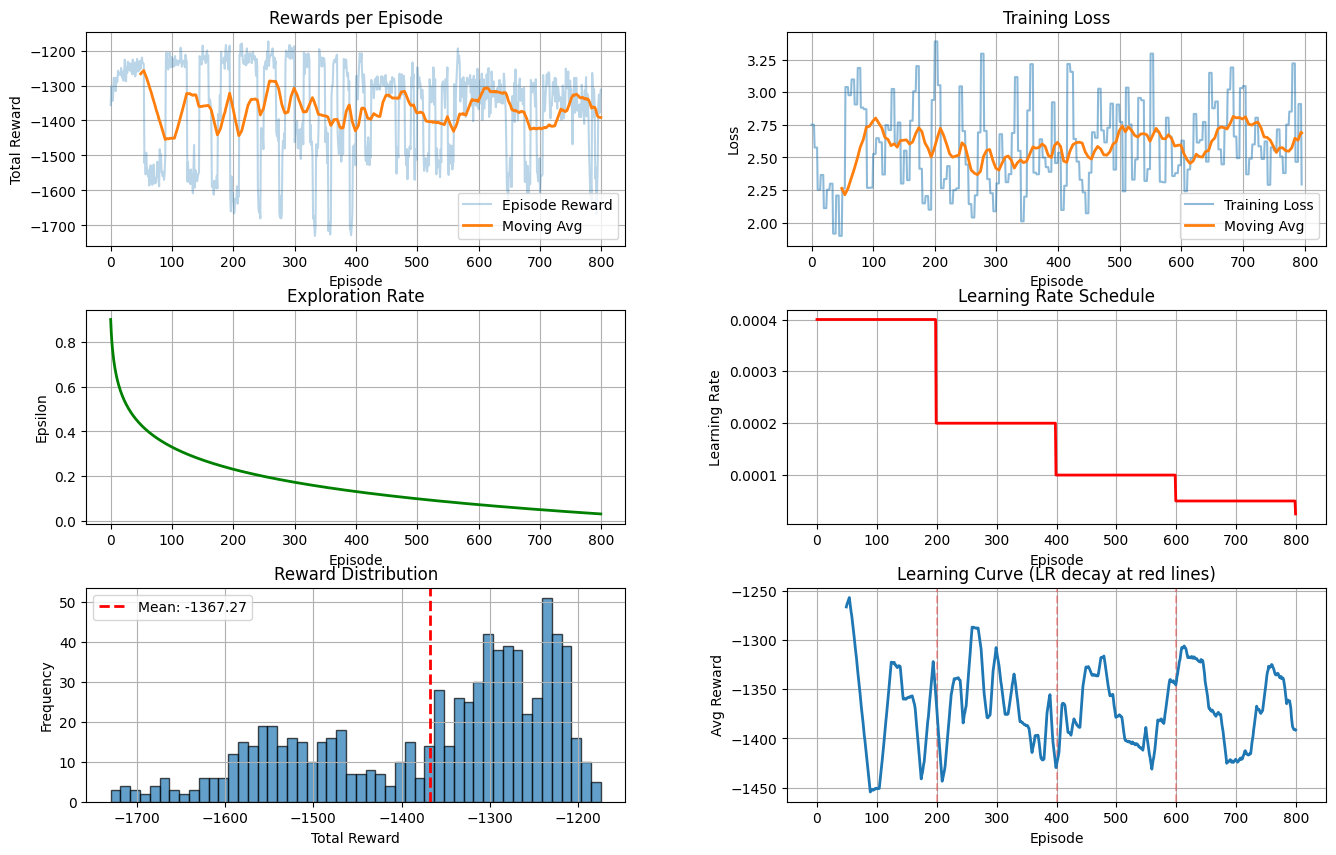

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize results of the experiment
visualize_training(rewards, losses, epsilon, lr)

figure_filename = f"ddqn_{simple_run_config['ID']}.png"
plt.savefig(figure_filename, dpi=300)

In [ ]:
print("=" * 70)
print("Flow-Line Maintenance Scheduling with Double DQN")
print("=" * 70)

# === CONFIGURATION FOR COMPLEX RUN ===
# Change 'ID' to train a separate model (e.g., "Experiment_A", "Experiment_B")
complex_run_config = {
    "ID": "Experiment_Complex",

    # Training Hyperparameters
    "episodes": 800,
    "episode_length": 1_000,
    "learning_rate": 0.0004,
    "lr_decay_factor": 0.5,
    "lr_decay_frequency": 200,
    "epsilon_decay_divisor": 3,
    "buffer_capacity": 5000,
    "batch_size": 128,
    "train_frequency": 5000,

    # Environment Parameters (Moved here so they are saved with the model)
    "env_params": {
        "machines_per_stage": [2, 2],
        "production_per_stage": [100, 100],
        "buffer_capacity": 1400,
        "buffer_cycle": 7,
        "arrival_lambda": 1_200,
        "max_machine_age": None,  # Calculates automatically
        "failure_distribution": "weibull",
        "weibull_k":  2,
        "weibull_lambda": 30,
        "pm_age_reduction": 14,
        "pm_duration": 2,
        "cm_duration": 5,
        "pm_cost": 6_000,
        "cm_cost": 8_000,
        "blockage_cost": 10,
        "starvation_cost": 5
    }
}


# 1. Setup Paths
# This creates a unique file for every ID: "ddqn_Experiment_A.pth", "ddqn_Experiment_B.pth"
save_dir = '/content/drive/My Drive/Maintenance_RL_Models'
os.makedirs(save_dir, exist_ok=True)

filename = f"ddqn_{complex_run_config['ID']}.pth"
checkpoint_path = os.path.join(save_dir, filename)

print(f"Run ID: {complex_run_config['ID']}")
print(f"Checkpoint File: {checkpoint_path}")

# 2. Create Environment
# We unpack the dictionary using ** to pass arguments cleanly
env = FlowLineEnvironment(
    **complex_run_config['env_params'],
    # Can add the static parameters that don't change often
)

# 3. Start Training
agent, rewards, losses, epsilon, lr = train_maintenance_system(
    env=env,
    config=complex_run_config,
    checkpoint_path=checkpoint_path
)

Flow-Line Maintenance Scheduling with Double DQN
Run ID: Experiment_Complex
Checkpoint File: /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Complex.pth
Auto-calculated max_machine_age: 77
No checkpoint found.
Episode 50/800 | Avg Reward: -5436512.10 | Avg Loss: 61923982.9565 | ε: 0.431 | LR: 0.000400

Checkpoint saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Complex.pth
Sample transitions saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Complex_sample.txt
----------------------------------------------------------------------
Episode 100/800 | Avg Reward: -3873197.00 | Avg Loss: 46990909.5200 | ε: 0.332 | LR: 0.000400

Checkpoint saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Complex.pth
Sample transitions saved to /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Complex_sample.txt
----------------------------------------------------------------------
Episode 150/800 | Avg Reward: -3347048.

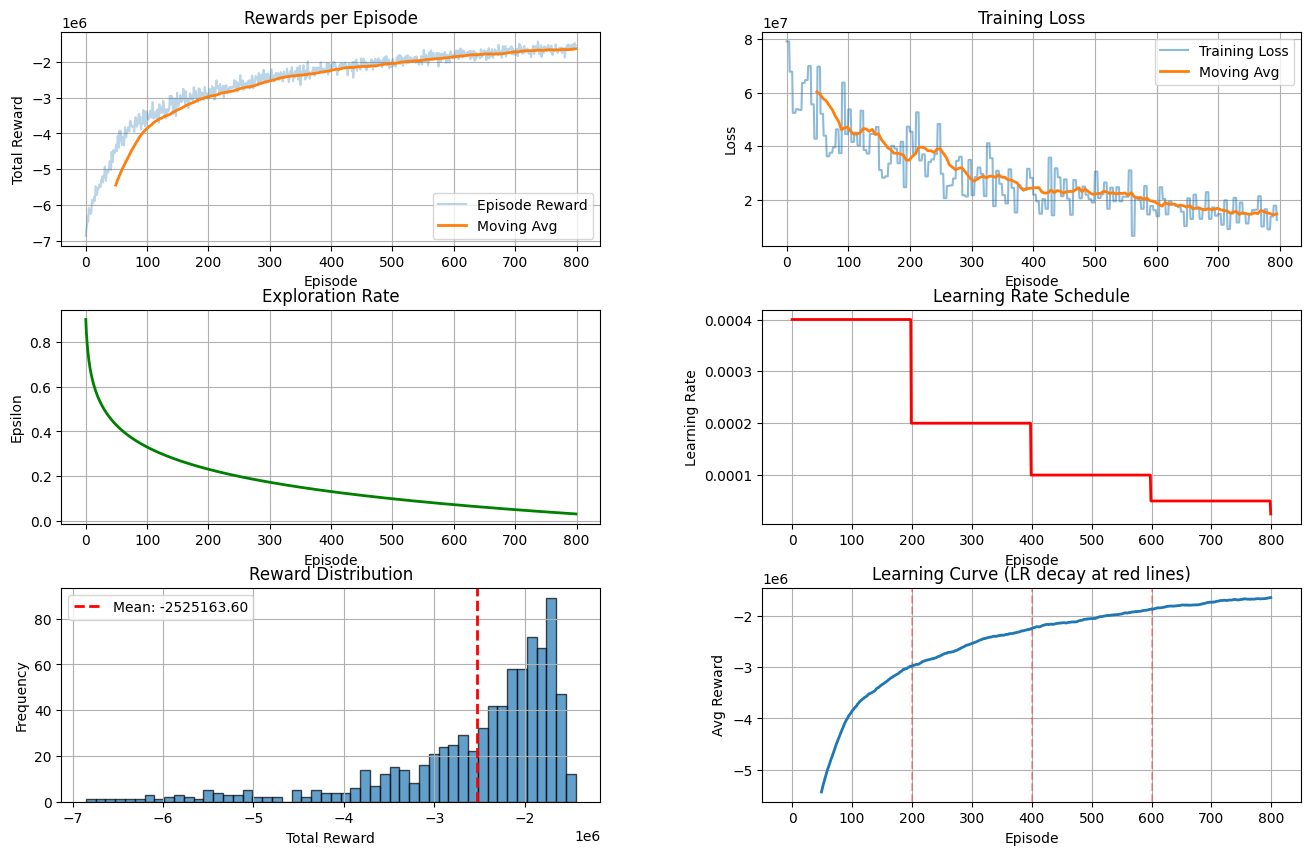

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize results of the experiment
visualize_training(rewards, losses, epsilon, lr)


In [ ]:
def load_trained_agent(env, checkpoint_path, config):
    """
    Creates an agent instance and loads weights from a file.
    """
    # 1. Initialize a fresh agent (structure must match training)
    agent = DoubleDQNAgent(
        state_size=env.state_size,
        action_size=env.action_size,
        num_agents=env.total_machines,
        # Hyperparams don't matter for evaluation, but we need valid inputs
        learning_rate=config["learning_rate"],
        epsilon_decay_divisor=config["epsilon_decay_divisor"],
        buffer_capacity=config["buffer_capacity"],
        train_frequency=config["train_frequency"],
        lr_decay_factor=config["lr_decay_factor"],
        lr_decay_frequency=config["lr_decay_frequency"]
    )

    # 2. Load the weights
    # We use the method in the agent class
    print(f"Loading model from: {checkpoint_path}")
    agent.load_checkpoint(checkpoint_path)

    # 3. Set to Evaluation Mode (No exploration)
    agent.epsilon = 0.0

    return agent

In [ ]:
def policy_run_to_failure(state, env):
    """Never perform PM. Only CM happens upon failure (handled by env)."""
    # Always return action 0 (Do Nothing) for all machines
    return [0] * env.total_machines

def policy_age_dependent(state, env, threshold_age):
    """Perform PM if a machine's age exceeds a fixed threshold."""
    actions = []
    # The first 'total_machines' elements of the state are the normalized ages
    normalized_ages = state[:env.total_machines]

    for norm_age in normalized_ages:
        # Denormalize to get actual age
        actual_age = norm_age * env.max_machine_age
        if actual_age >= threshold_age:
            actions.append(1) # Perform PM
        else:
            actions.append(0) # Do Nothing
    return actions

In [ ]:
def evaluate_policies(env, agent, policies, num_episodes=20):
    """
    Evaluates the trained agent against baseline policies.
    """
    results = {}

    print(f"Starting evaluation over {num_episodes} episodes per policy...")

    for name, policy_func in policies.items():
        print(f"Evaluating: {name}")
        policy_rewards = []

        for _ in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                if name == "Double DQN":
                    # Use the trained agent (exploit only, epsilon=0)
                    original_epsilon = agent.epsilon
                    agent.epsilon = 0.0
                    actions = agent.choose_actions(state)
                    agent.epsilon = original_epsilon # restore epsilon
                else:
                    # Use the baseline policy function
                    actions = policy_func(state, env)

                next_state, reward = env.step(actions)
                total_reward += reward
                state = next_state
                done = env.is_episode_done()

            policy_rewards.append(total_reward)

        results[name] = policy_rewards
        print(f"  -> Avg Reward: {np.mean(policy_rewards):.2f}")

    return results

In [ ]:
def compare_policies(config, eval_policies, eval_episodes):
  global save_dir

  # Ensure your environment is reset with the same parameters used for training
  eval_env = FlowLineEnvironment(
      **config['env_params']
  )

  assert save_dir is not None, "Checkpoint directory path 'save_dir' has not been set."

  filename = f"ddqn_{config['ID']}.pth"
  checkpoint_path = os.path.join(save_dir, filename)
  eval_agent = load_trained_agent(eval_env, checkpoint_path, config)

  # --- Run Evaluation ---
  # Assuming 'agent' is your trained DoubleDQNAgent instance from the training block
  eval_results = evaluate_policies(eval_env, eval_agent, eval_policies, num_episodes=eval_episodes)

  # --- Box Plot ---
  # Convert results to a DataFrame for plotting with Seaborn
  df_results = pd.DataFrame(eval_results)

  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df_results, palette="viridis")

  plt.title("Comparison of Accumulated Rewards (Costs) over 1000 Steps", fontsize=14)
  plt.ylabel("Accumulated Reward (Negative Cost)", fontsize=12)
  plt.xlabel("Policy Method", fontsize=12)
  plt.grid(True, axis='y', linestyle='--', alpha=0.7)
  plt.xticks(rotation=0) # Keep labels horizontal

  plt.tight_layout()
  plt.show()

  figname = f"ddqn_{config['ID']}_comparison.png"
  figpath = os.path.join(save_dir, figname)
  plt.savefig(figpath, dpi=300)

  print("\nDetailed Statistics:")
  print(df_results.describe().loc[['mean', 'std', 'min', 'max']].T)

Auto-calculated max_machine_age: 118
Loading model from: /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Simple_1_Machine.pth
Successfully loaded model.
Starting evaluation over 30 episodes per policy...
Evaluating: Double DQN
  -> Avg Reward: -1366.93
Evaluating: Weekly (Age >= 7)
  -> Avg Reward: -1781.20
Evaluating: Biweekly (Age >= 14)
  -> Avg Reward: -1783.20
Evaluating: Monthly (Age >= 30)
  -> Avg Reward: -1782.47
Evaluating: Run-to-Fail
  -> Avg Reward: -1777.33


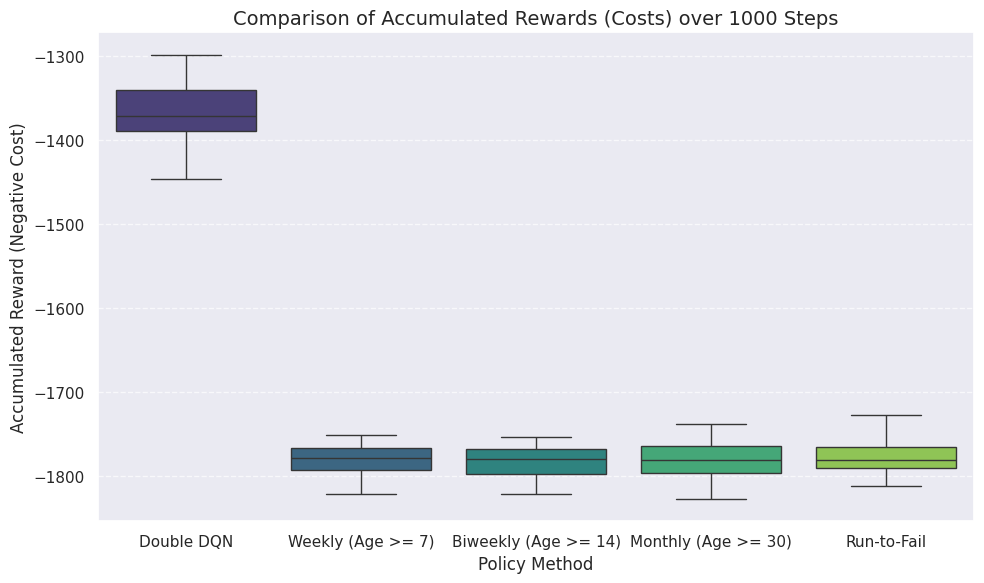


Detailed Statistics:
                             mean        std     min     max
Double DQN           -1366.933333  39.289319 -1446.0 -1298.0
Weekly (Age >= 7)    -1781.200000  18.861382 -1822.0 -1752.0
Biweekly (Age >= 14) -1783.200000  18.744011 -1822.0 -1754.0
Monthly (Age >= 30)  -1782.466667  25.513665 -1828.0 -1738.0
Run-to-Fail          -1777.333333  21.213745 -1812.0 -1728.0


<Figure size 640x480 with 0 Axes>

In [ ]:
# Define the specific thresholds for weekly, biweekly, monthly
# Assuming 1 timestep = 1 day (adjust based on your simulation's time scale)
# 'weekly' -> PM every 7 steps
# 'biweekly' -> PM every 14 steps
# 'monthly' -> PM every 30 steps
simple_policies = {
    "Double DQN": None, # Placeholder, uses the trained agent
    "Weekly (Age >= 7)": lambda s, e: policy_age_dependent(s, e, threshold_age=7),
    "Biweekly (Age >= 14)": lambda s, e: policy_age_dependent(s, e, threshold_age=14),
    "Monthly (Age >= 30)": lambda s, e: policy_age_dependent(s, e, threshold_age=30),
    "Run-to-Fail": policy_run_to_failure
}

compare_policies(simple_run_config, simple_policies, 30)

Auto-calculated max_machine_age: 77
Loading model from: /content/drive/My Drive/Maintenance_RL_Models/ddqn_Experiment_Complex.pth
Successfully loaded model.
Starting evaluation over 30 episodes per policy...
Evaluating: Double DQN
  -> Avg Reward: -1392322.67
Evaluating: Weekly (Age >= 7)
  -> Avg Reward: -2957188.00
Evaluating: Biweekly (Age >= 14)
  -> Avg Reward: -1840949.50
Evaluating: Monthly (Age >= 30)
  -> Avg Reward: -1618012.17
Evaluating: Run-to-Fail
  -> Avg Reward: -1395293.67


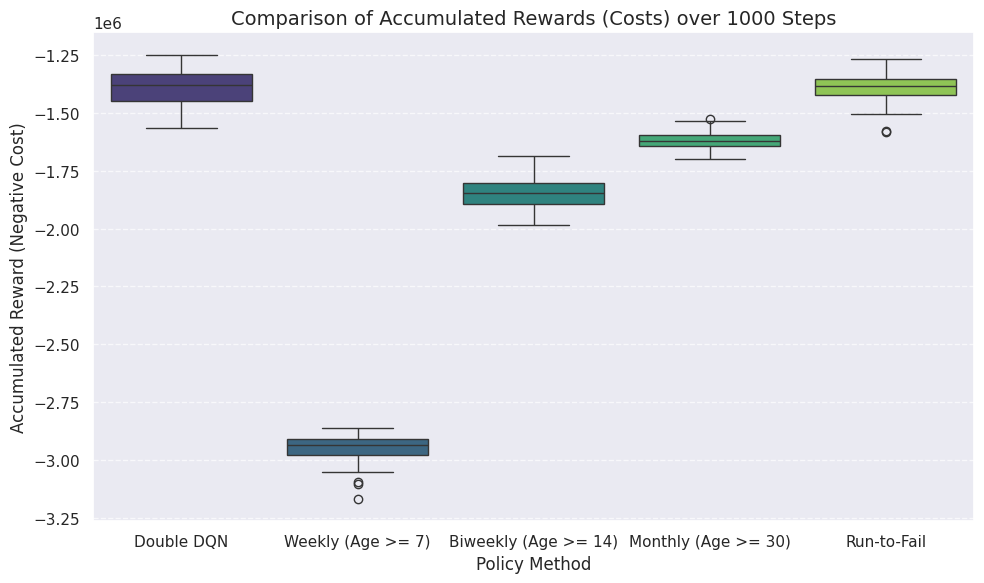


Detailed Statistics:
                              mean           std        min        max
Double DQN           -1.392323e+06  89904.491591 -1564540.0 -1247550.0
Weekly (Age >= 7)    -2.957188e+06  72379.290387 -3168740.0 -2862910.0
Biweekly (Age >= 14) -1.840950e+06  75337.905573 -1986280.0 -1685635.0
Monthly (Age >= 30)  -1.618012e+06  44916.957720 -1698835.0 -1525905.0
Run-to-Fail          -1.395294e+06  74967.957948 -1583660.0 -1264690.0


<Figure size 640x480 with 0 Axes>

In [ ]:
complex_policies = {
    "Double DQN": None, # Placeholder, uses the trained agent
    "Weekly (Age >= 7)": lambda s, e: policy_age_dependent(s, e, threshold_age=7),
    "Biweekly (Age >= 14)": lambda s, e: policy_age_dependent(s, e, threshold_age=14),
    "Monthly (Age >= 30)": lambda s, e: policy_age_dependent(s, e, threshold_age=30),
    "Run-to-Fail": policy_run_to_failure
}

compare_policies(complex_run_config, complex_policies, 30)